### Chapter 11: Partial differential equations (PDEs)
* multivariate equations with derivatives of >1 dependent variables (ie, derivatives in equation are partial derivatives)
 Two common techniques: 1) finite-difference methods (FDMs: derivatives are approximated), and 2) finite-element methods (FEMs - unknown funct written as linear combination of simple basis functions)
* PDE solvers == **much** more computationally demanding due to #points expanding exponentially with #dimensions. Heavy reliance on sparse matrix operations

In [1]:
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d

In [3]:
import scipy.sparse as sp
import scipy.sparse.linalg
import scipy.linalg as la

In [4]:
# FEniCS FEM framework
import dolfin
import mshr

ModuleNotFoundError: No module named 'dolfin'

- typical use case: heat equations (2D cartesian coordinates, where $u=(t,x,y)$ describes temperature at a spatial & temporal point.
- To specify a PDE solution we need to define its *boundary conditions*, and initial values (if the problem is time-dependent.)
- Two important types of boundary conditions:
    - **Dirichlet** (describes function values at the boundary)
    - **Neumann** (describes a normal derivative at the boundary).

### Finite-difference methods
- Basic idea: *approximate the derivatives with their finite-difference formulas on a discretized space*. Assuming sufficient granularity, FD formulas can provide good approximations.
- Replacing ODE/PDE derivatives with FD formulas recasts the equations as algebraic equations. If the original ODE/PDE is linear, so is the algebra.
- Example: Steady-state heat equation:
    $$u_{xx}=-5, u(x=0)=1, u(x=1)=2$$
    $$u_{xx}[n]=(u[n-1]-2u[n]+u[n+1])/dx^2$$

In [5]:
N     = 5          # interior points
u0,u1 = 1,2        # function values at boundaries
dx    = 1.0/(N+1)  # spacing between neighboring points

- A describes the coupling of the equations for $u_n$ to values at neighboring points due to the finite-difference formula that was used to approximate the second-order derivative in the ODE. 
- The boundary values are included in $b$, which also contains the constant right-hand side of the original ODE (the source term).
- We can solve $Au = b$ for u and thereby get the approximate values of the u(x) at the discrete points ${x_n}$.

In [6]:
# equation for interior points = Au=b
A = ((np.eye(N, k=-1) - 2*np.eye(N) + np.eye(N, k=1))) / dx**2
A

array([[-72.,  36.,   0.,   0.,   0.],
       [ 36., -72.,  36.,   0.,   0.],
       [  0.,  36., -72.,  36.,   0.],
       [  0.,   0.,  36., -72.,  36.],
       [  0.,   0.,   0.,  36., -72.]])

- Next: define an array for the vector b, which corresponds to the source term –5 in the differential equation, as well as the boundary condition. 
- The boundary conditions enter into the equations via the FD expressions for the derivatives of the first and the last equation ( $u_1$ and $u_N$), but these terms are missing from the expression represented by A and must be added to b.

In [7]:
# define b (a vector)
b       = -5*np.ones(N)
b[0]   -= u0/dx**2
b[N-1] -= u1/dx**2
b

array([-41.,  -5.,  -5.,  -5., -77.])

In [8]:
# apply SciPy linear equation solver (can also use np.linalg.solve)
u = np.linalg.solve(A,b); print(u)

[1.51388889 1.88888889 2.125      2.22222222 2.18055556]


- This completes the solution of this ODE. To visualize the solution, create an array x that contains the discrete coordinate points for which we have solved the problem, including the boundary points.
- Also create an array U that combines the boundary values and the interior points in one array.

In [9]:
x = np.linspace(0, 1, N+2)
U = np.hstack([[u0], u, [u1]])

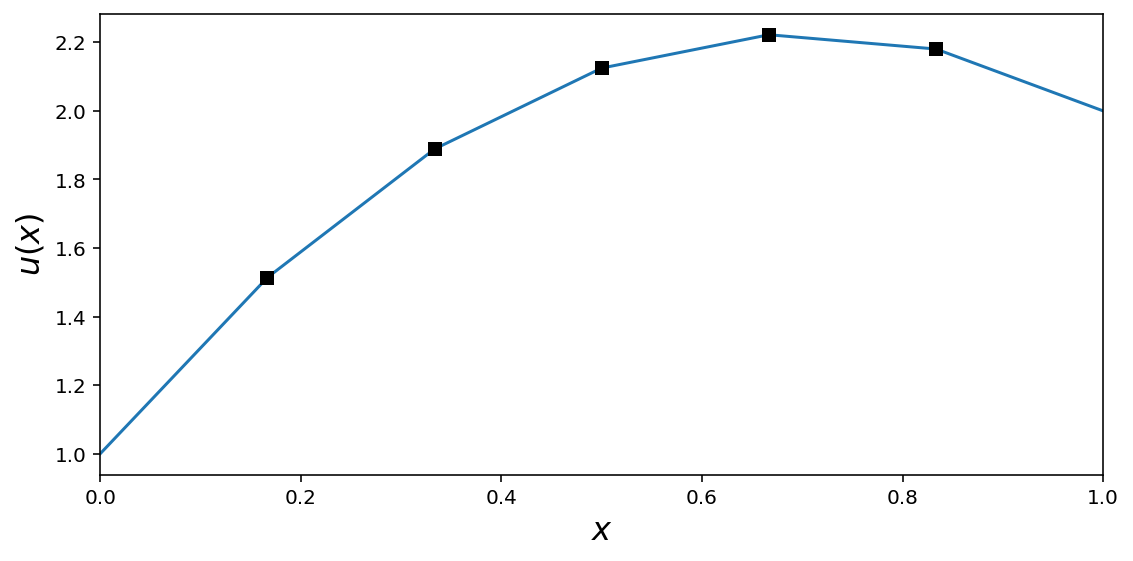

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, U)
ax.plot(x[1:-1], u, 'ks')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=16)
ax.set_ylabel(r"$u(x)$", fontsize=16)
#fig.savefig("ch11-fdm-1d.pdf")
fig.tight_layout();

### Extending Finite Differences to 2D
- u = 2D array of unknown interior function values 
- laplace equation: $u_{xx} + u_{yy} = 0$
- boundary conditions:
    - $u(x=0)= 3$, $u(x=1)=-1$
    - $u(y=0)=-5$, $u(y=1)= 5$

In [11]:
N = 100               # number of interior points
u0_t, u0_b = 5, -5    # boundary values of unit square
u0_l, u0_r = 3, -1
dx = 1.0/(N+1)        # separation betw uniformly spaced points

In [12]:
# Construct A that describes FD system for a 2D PDE
# First, define 1D formula along one coordinate
A_1d = (sp.eye(N,k=-1) + sp.eye(N,k=1) - 4*sp.eye(N)) / (dx**2)

In [13]:
# A = very sparse matrix (49.6K non-zero, 10e8 total)
A = sp.kron(sp.eye(N),A_1d) + (sp.eye(N**2,k=-N) + sp.eye(N**2,k=N)) / (dx**2)
A

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 49600 stored elements in Compressed Sparse Row format>

In [14]:
# sparsity
A.nnz * 1.0/ np.prod(A.shape) * 2000

0.992

In [15]:
# construct vector b from boundary conditions:
# create NxN of zeros & assign boundary conditions to edge elements
# then reshape to a N^2x1 vector for use in Av=b equation.
b = np.zeros((N, N))

b[0,  :] += u0_b # bottom
b[-1, :] += u0_t # top
b[:,  0] += u0_l # left
b[:, -1] += u0_r # right

b = b.reshape(N**2) / dx**2; b.shape

(10000,)

In [16]:
# solve for v, then reshape back to NxN
u = sp.linalg.spsolve(A,b).reshape(N, N)
u.shape

(100, 100)

In [17]:
# for plotting - combine u with boundary conditions
U = np.vstack(
    [np.ones((1,N+2))*u0_b,
     np.hstack([np.ones((N,1))*u0_l, 
                u, 
                np.ones((N,1))*u0_r]),
     np.ones((1,N+2))*u0_t])

<ipython-input-18-87805b07d886>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))


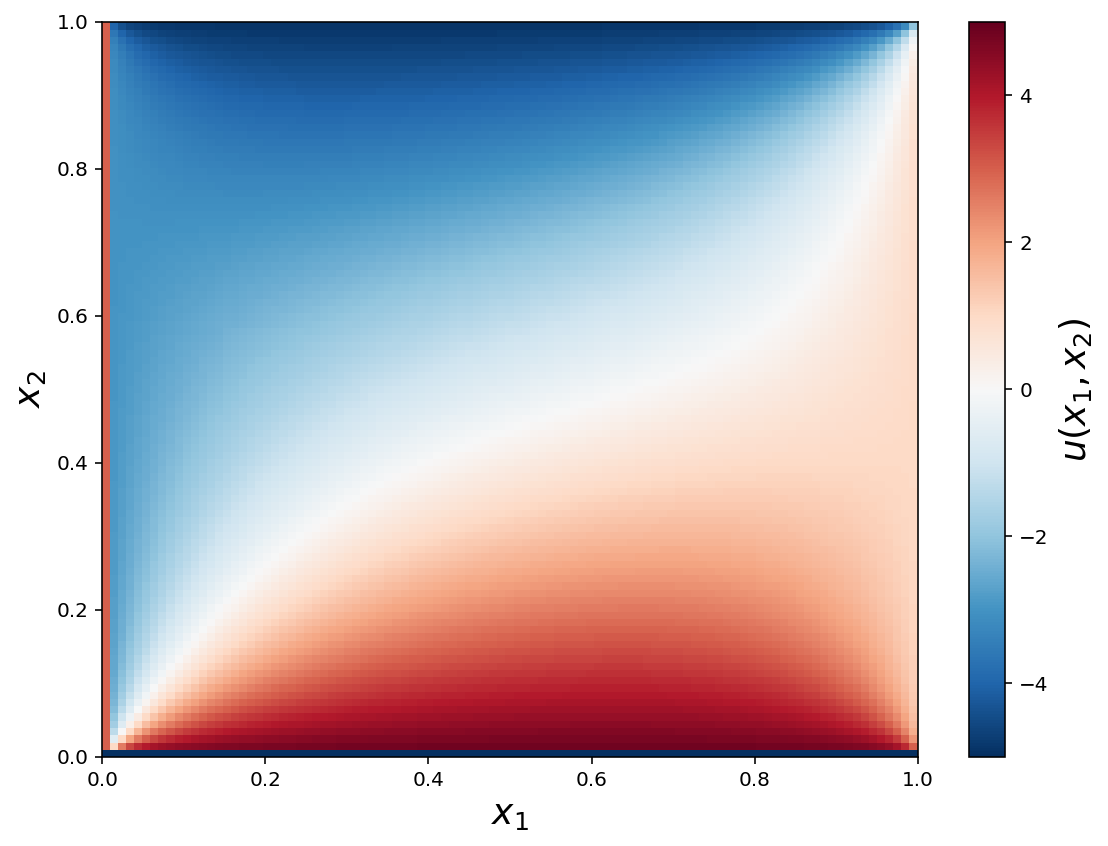

In [18]:
# plot 2D heat equation with Dirichlet boundary conditions
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)

c = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)
#fig.savefig("ch11-fdm-2d.pdf")
fig.tight_layout()

<ipython-input-19-e28d100f7374>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p    = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)


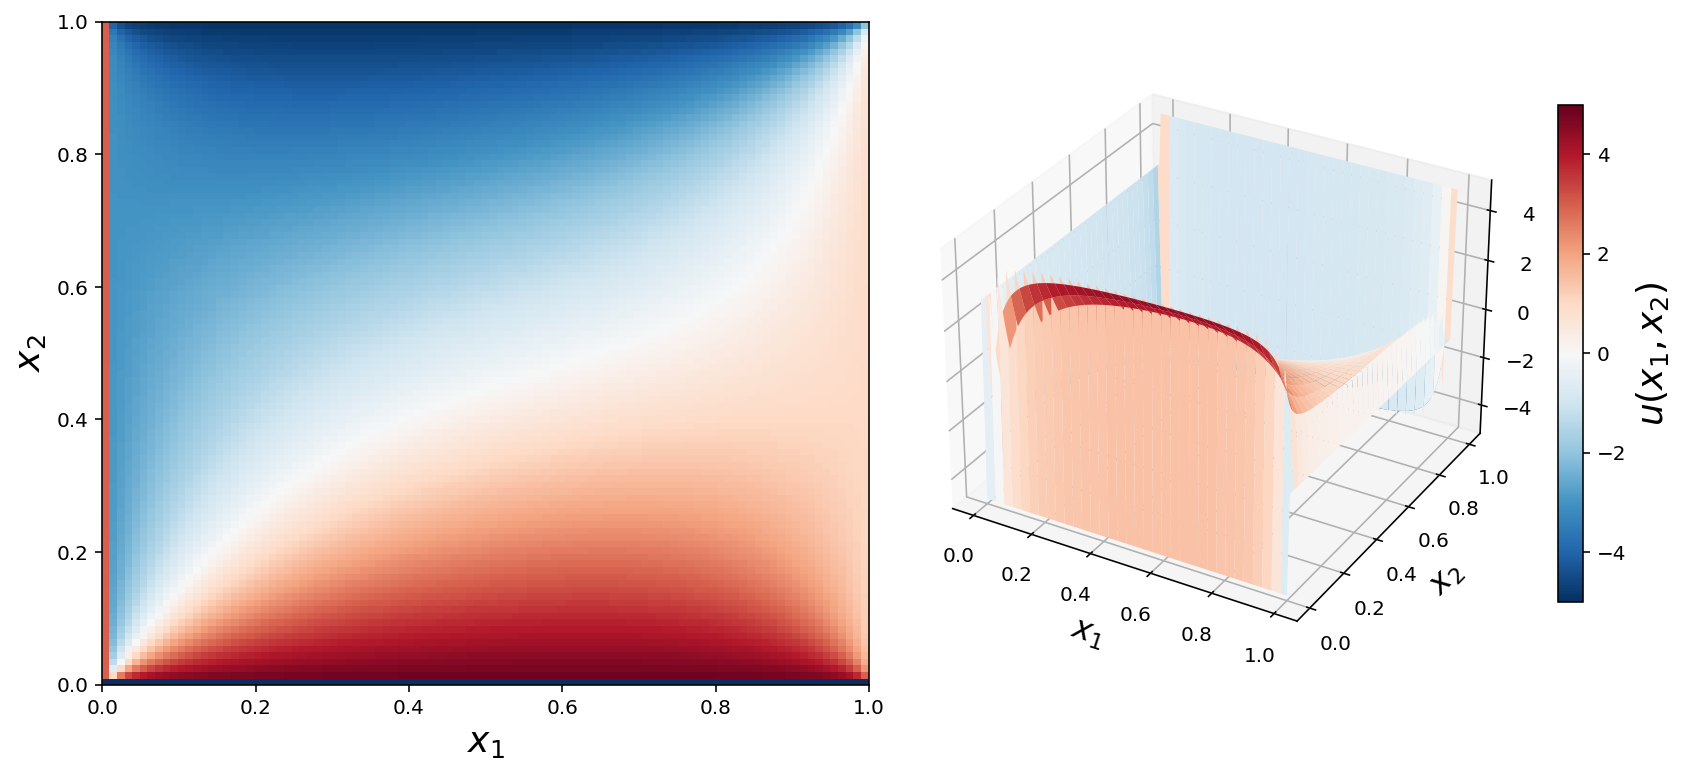

In [19]:
# 3D surface map of solution
x    = np.linspace(0, 1, N+2)
X, Y = np.meshgrid(x, x)
fig  = plt.figure(figsize=(12, 5.5))
cmap = mpl.cm.get_cmap('RdBu_r')
ax   = fig.add_subplot(1, 2, 1)
p    = ax.pcolor(X, Y, U, vmin=-5, vmax=5, cmap=cmap)

ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)

ax = fig.add_subplot(1, 2, 2, projection='3d')
p  = ax.plot_surface(X, Y, U, vmin=-5, vmax=5, rstride=3, cstride=3, linewidth=0, cmap=cmap)
ax.set_xlabel(r"$x_1$", fontsize=16)
ax.set_ylabel(r"$x_2$", fontsize=16)
cb = plt.colorbar(p, ax=ax, shrink=0.75)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)

#fig.savefig("ch11-fdm-2d.pdf")
#fig.savefig("ch11-fdm-2d.png")
fig.tight_layout()

### Compare performance when using dense/sparse matrices

In [20]:
A_dense = A.todense()

In [23]:
dense_solver_time = %timeit np.linalg.solve(A_dense, b)
dense_solver_time

4.91 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
sparse_solver_time = %timeit sp.linalg.spsolve(A, b)
sparse_solver_time

69.1 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- The finite-difference method that we used in the last two examples is a powerful and relatively simple method for solving ODE boundary value problems and PDE problems with simple geometries. 
- However, it is not so easily adapted to problems on more complicated domains or problems on nonuniform coordinate grids. For such problems finite-element methods are typically more flexible and convenient to work with, and although FEMs are conceptually more complicated than FDMs, they can be computationally efficient and adapt well to complicated problem domains and more involved boundary conditions.

### Finite-Element Methods
- A strategy for converting PDEs into algebra
- Idea: represent domain with a set of discrete regions (elements) & approximate the unknown function as a *linear combination of basis functions*
- In practice, a very large number of basis functions can be required to obtain a good approximation to the exact solution, and the linear equation system generated by FEMs is therefore often very large. However, the fact that each basis function has support only at one or a few nearby elements in the discretization of the problem domain ensures that the matrix A is sparse, which makes it tractable to solve.
- Typical examples of basis functions are low-order polynomials that are nonzero only within a single element.

- When using FEM to solve a PDE, you typically need to convert the PDE to weak form by hand, and rewrite it in bilinear form: *a(u,v)=L(v)*.
- You'll also need to discretize the problem, ie "mesh it". There are tools for auto-generating meshes for simplier geometries.

### FEM Libraries
- [FiPy](http://www.ctcms.nist.gov/fipy)
- [SfePy](http://sfepy.org)
- **FEniCS** (used in this example)
    - [dolfin](): Python interface to FEniCS
    - [mshr](): mesh generation library
    
### Dolfin functions/classes
![dolfin functions](pics/dolfin-api-p1.png)
![more](pics/dolfin-api-p2.png)
![dolfin/mshr](pics/dolfin-mshr-funcs.png)

### Setup
- reconsider steady-state 2D heat equation previously solved.
- assume boundary conditions: 
    - u(x=0,y) = u(x=1,y) = 0
    - u(x,y=0) = u(x,y=1) = 0
- first step: define discretization mesh. In this simple case, use a *unit square* as the problem domain. Use **RectangleMesh** to generate it.

In [25]:
# dolfin configuration
dolfin.parameters["reorder_dofs_serial"] = False
dolfin.parameters["allow_extrapolation"] = True

In [28]:
N1 = N2 = 75
mesh = dolfin.RectangleMesh(
    dolfin.Point(0,0),
    dolfin.Point(1,1),N1,N2)
mesh

- Next: define representation of function space for the *trial* and *test* functions. The constructor needs a mesh object, the name of the basis function, and the degree of the basis function.

In [29]:
V = dolfin.FunctionSpace(mesh,'Lagrange',1)

- Create objects for trial function (u) and test function (v), which will define the PDE's weak form.

In [30]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

- Next, rewrite & transform the direct integrals. In this case we need symbolics for the *inner product*, the *gradients* of u & v, and the integration measure $dx$. 
- Use dolfin's *inner*, *nabla_grad* & *dx* functions for this.

In [31]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

- For right side of equation, we need representation of $b(v)=fv dx$.

In [32]:
f1 = dolfin.Constant(1.0)
L1 = f1 * v * dolfin.dx

- The constructor of this object takes a string that contains an expression that corresponds to the function. 
- This expression must be defined in C++ syntax, since the FEniCS framework automatically generates and compiles a C++ function for efficient evaluation.

In [33]:
f2 = dolfin.Expression("x[0]*x[0] + x[1]*x[1]", degree=1)
L2 = f2 * v * dolfin.dx

- Next: boundary conditions. Using simple uniform Dirichlet-type boundary.
- dolfin also has *DirichletBC*, but a constant is OK for describing u=0 along entire boundary.

In [34]:
u0 = dolfin.Constant(0)

In [35]:
def u0_boundary(x, on_boundary):
    # try to pin down the function at some interior region:
    #if np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2) < 0.1:
    #    return True
    return on_boundary

- Once we have boundary value expression & a function for selecting the boundary from mesh vertices (u0_boundary), we can create the Dirichlet BC object.

In [36]:
bc = dolfin.DirichletBC(V, u0, u0_boundary)

### Solve the problem
- Next: convert to algebraic form by assembling the matrix & vector from the PDE weak form.

In [37]:
A = dolfin.assemble(a)
b = dolfin.assemble(L1)
bc.apply(A,b)

- create function object for storing unknown solution, then calling *solve*.

In [38]:
u_sol1 = dolfin.Function(V)
dolfin.solve(A, u_sol1.vector(), b)

1

In [39]:
u_sol2 = dolfin.Function(V)
dolfin.solve(a == L2, u_sol2, bc)

### Dolfin plot
- <div style="color:red;">DOESN'T MATCH TEXTBOOK IMAGE</div>

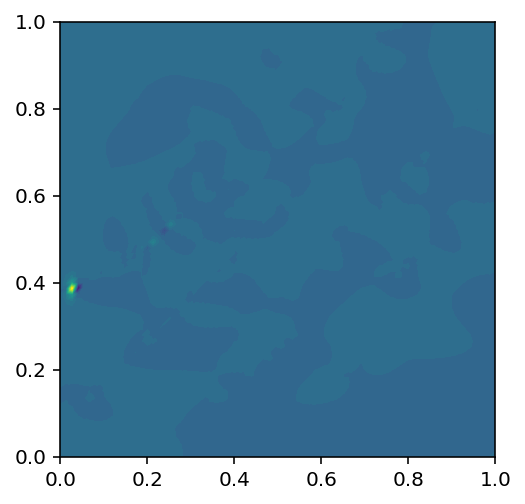

In [40]:
dolfin.plot(u_sol2)

### Export ParaView-compatible images

In [42]:
#dolfin.File('u_sol1.pvd') << u_sol1
#dolfin.File('u_sol2.pvd') << u_sol2

In [41]:
#f = dolfin.File('combined.pvd')
#f << mesh
#f << u_sol1
#f << u_sol2

### Function evaluation
- It might be preferable to work within, for example, Jupyter Notebook for visualization of the solutions and the mesh. For relatively simple problems we can use Matplotlib. To be able to use Matplotlib, we need a NumPy array with data corresponding to the FEniCS function object. There are several ways to construct such arrays. To begin with, the FEniCS function object can be called like a function, with an array (list) of coordinate values:

In [43]:
u_sol1([0.21, 0.67])

-83.2366634042341

### Obtain NumPy arrays
- <div style="color:red;">DOESN'T MATCH TEXTBOOK IMAGE</div>

In [44]:
u_mat1 = np.array(u_sol1.vector()).reshape(N1+1, N2+1)
u_mat2 = np.array(u_sol2.vector()).reshape(N1+1, N2+1)

In [45]:
X, Y = np.meshgrid(np.linspace(0, 1, N1+2), np.linspace(0, 1, N2+2))

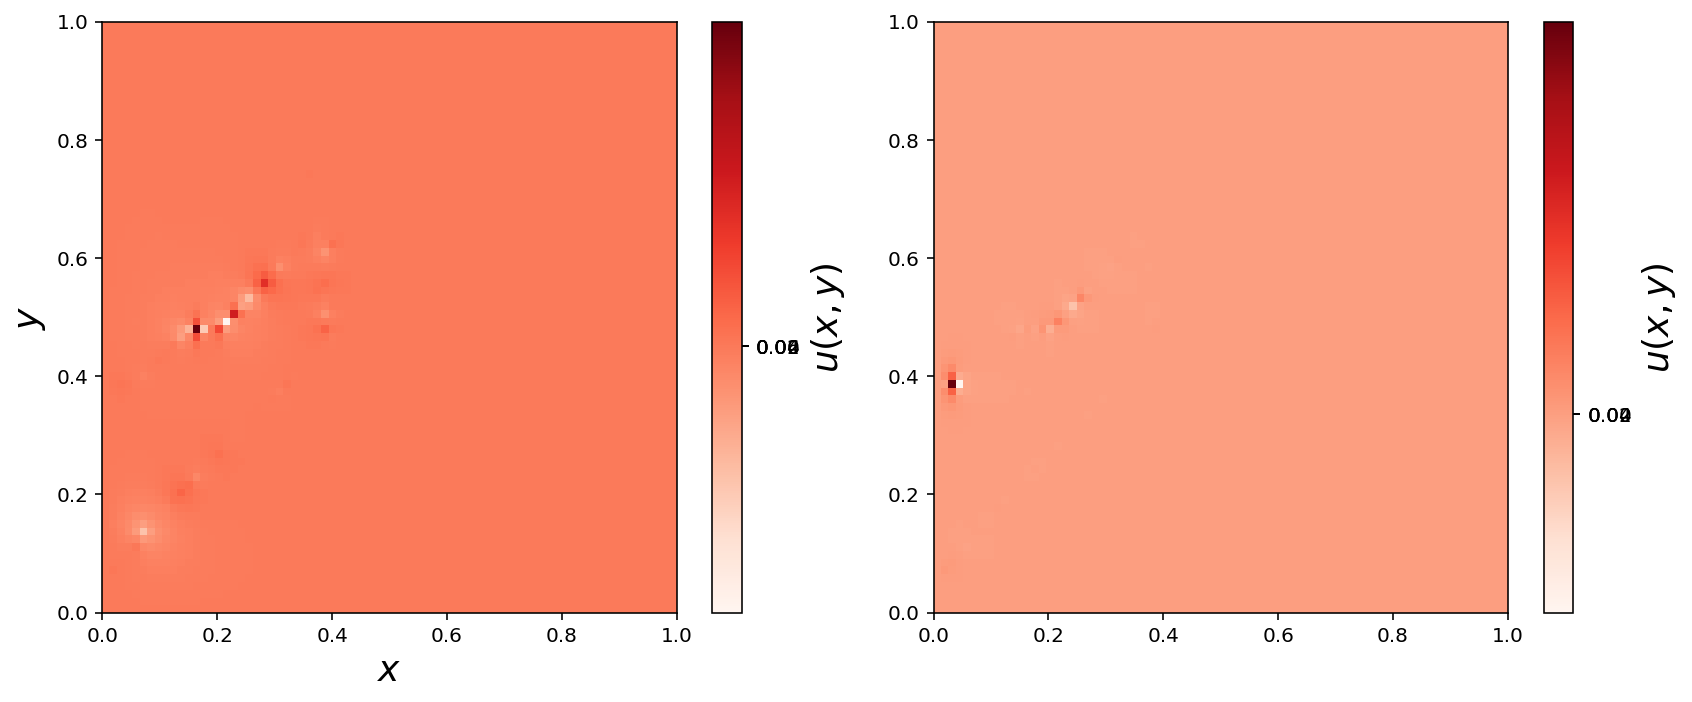

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
cmap = mpl.cm.get_cmap('Reds')

c = ax1.pcolor(X, Y, u_mat1, cmap=cmap)
cb = plt.colorbar(c, ax=ax1)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04, 0.06])

c = ax2.pcolor(X, Y, u_mat2, cmap=cmap)
cb = plt.colorbar(c, ax=ax2)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04])

fig.savefig("ch11-fdm-2d-ex1.pdf")
fig.savefig("ch11-fdm-2d-ex1.png")
fig.tight_layout()

### Triangulation
- The above method works for rectangular meshes. The *Mesh* object contains coordinates for each vertex - when combined with a *Function* object, they can be plotted using Matplotlib's *triplot* and *tripcolor* functions.
<div style="color:red;">DOES NOT MATCH BOOK IMAGES</div>

In [47]:
coordinates = mesh.coordinates()
triangles = mesh.cells()
triangulation = mpl.tri.Triangulation(coordinates[:, 0], 
                                      coordinates[:, 1], 
                                      triangles)

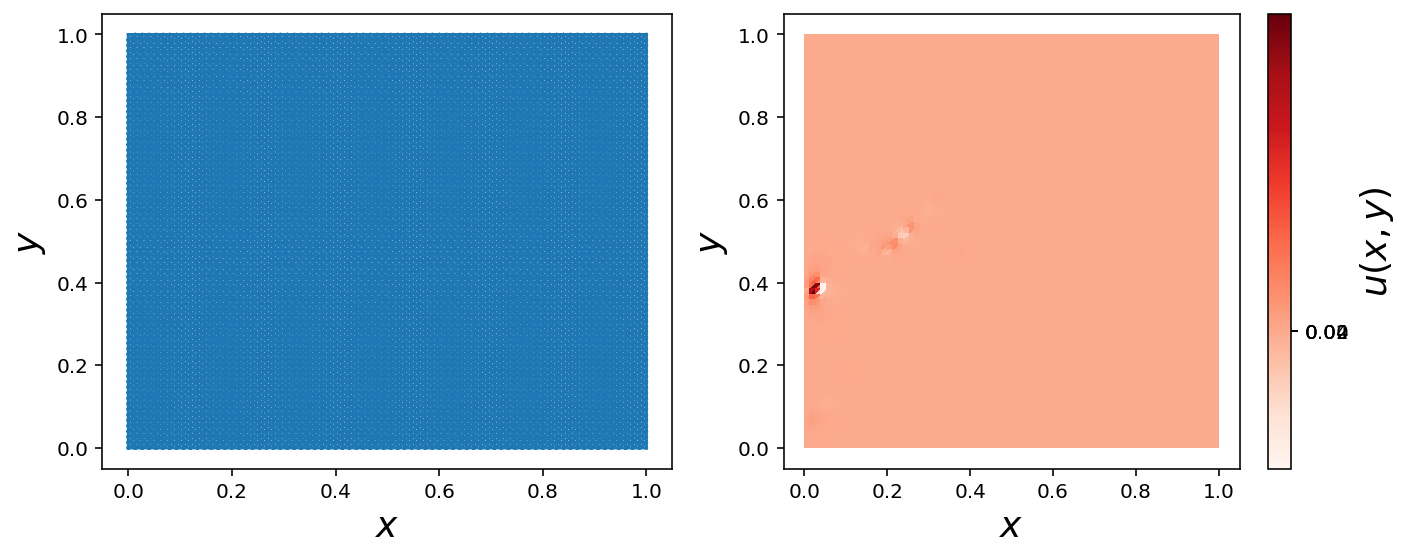

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation,
                  np.array(u_sol2.vector()), 
                  cmap=cmap)
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 0.02, 0.04])

#fig.savefig("ch11-fdm-2d-ex2.pdf")
#fig.savefig("ch11-fdm-2d-ex2.png")
fig.tight_layout()

## Dirichlet boundary conditions

In [ ]:
N1 = N2 = 75

In [ ]:
mesh = dolfin.RectangleMesh(0, 0, 1, 1, N1, N2)

In [ ]:
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)

In [ ]:
u = dolfin.TrialFunction(V)

In [ ]:
v = dolfin.TestFunction(V)

In [ ]:
a = dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v)) * dolfin.dx

In [ ]:
f = dolfin.Constant(0.0)

In [ ]:
L = f * v * dolfin.dx

In [ ]:
def u0_top_boundary(x, on_boundary):
    return on_boundary and abs(x[1]-1) < 1e-8

In [ ]:
def u0_bottom_boundary(x, on_boundary):
    return on_boundary and abs(x[1]) < 1e-8

In [ ]:
def u0_left_boundary(x, on_boundary):
    return on_boundary and abs(x[0]) < 1e-8

In [ ]:
def u0_right_boundary(x, on_boundary):
    return on_boundary and abs(x[0]-1) < 1e-8

In [ ]:
bc_t = dolfin.DirichletBC(V, dolfin.Constant(5), u0_top_boundary)
bc_b = dolfin.DirichletBC(V, dolfin.Constant(-5), u0_bottom_boundary)
bc_l = dolfin.DirichletBC(V, dolfin.Constant(3), u0_left_boundary)
bc_r = dolfin.DirichletBC(V, dolfin.Constant(-1), u0_right_boundary)

In [ ]:
bcs = [bc_t, bc_b, bc_r, bc_l]

In [ ]:
u_sol = dolfin.Function(V)

In [ ]:
dolfin.solve(a == L, u_sol, bcs)

In [ ]:
u_mat = u_sol.vector().array().reshape(N1+1, N2+1)

In [ ]:
x = np.linspace(0, 1, N1+2)
y = np.linspace(0, 1, N1+2)
X, Y = np.meshgrid(x, y)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

c = ax.pcolor(X, Y, u_mat, vmin=-5, vmax=5, cmap=mpl.cm.get_cmap('RdBu_r'))
cb = plt.colorbar(c, ax=ax)
ax.set_xlabel(r"$x_1$", fontsize=18)
ax.set_ylabel(r"$x_2$", fontsize=18)
cb.set_label(r"$u(x_1, x_2)$", fontsize=18)
fig.savefig("ch11-fdm-2d-ex3.pdf")
fig.savefig("ch11-fdm-2d-ex3.png")
fig.tight_layout()

### Circular geometry
- The true strength of FEM becomes apparent when handling PDEs with more complicated problem geometries. 
- Consider the heat equation on a unit circle perforated by five smaller circles, one centered at the origin and the other four smaller circles. - To generate meshes for geometries like this one, we can use the mshr library. It provides geometric primitives (Point, Circle, Rectangle, etc.) that can be used in algebraic (set) operations.
- Here we first create a unit circle, centered at (0, 0), using mshr.Circle, and subtract from it other Circle objects corresponding to the part of the mesh that should be removed.

In [51]:
r_outer = 1
r_inner = 0.25
r_middle = 0.1
x0, y0 = 0.4, 0.4

In [52]:
domain = mshr.Circle(dolfin.Point(.0, .0), r_outer) \
    - mshr.Circle(dolfin.Point(.0, .0), r_inner) \
    - mshr.Circle(dolfin.Point( x0,  y0), r_middle) \
    - mshr.Circle(dolfin.Point( x0, -y0), r_middle) \
    - mshr.Circle(dolfin.Point(-x0,  y0), r_middle) \
    - mshr.Circle(dolfin.Point(-x0, -y0), r_middle)

In [54]:
mesh = mshr.generate_mesh(domain, 10); mesh

- A physical interpretation: a cross section of five pipes through a block of material: the inner pipe carries a hot fluid; the outer pipes a cold fluid for cooling the material block (e.g., an engine cylinder surrounded by cooling pipes).

In [56]:
def u0_outer_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_outer) < 5e-2

In [57]:
def u0_inner_boundary(x, on_boundary):
    x, y = x[0], x[1]
    return on_boundary and abs(np.sqrt(x**2 + y**2) - r_inner) < 5e-2

In [58]:
def u0_middle_boundary(x, on_boundary):
    x, y = x[0], x[1]
    if on_boundary:
        for _x0 in [-x0, x0]:
            for _y0 in [-y0, y0]:
                if abs(np.sqrt((x+_x0)**2 + (y+_y0)**2) - r_middle) < 5e-2:
                    return True
    
    return False

In [59]:
# define function space, trial function, test function
# build weak-form representation of the PDE
V = dolfin.FunctionSpace(mesh,'Lagrange',1)
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)
a = dolfin.inner(dolfin.nabla_grad(u),
                 dolfin.nabla_grad(v)) * dolfin.dx
f = dolfin.Constant(0.0)
L = f*v*dolfin.dx
u_sol = dolfin.Function(V)

In [61]:
bc_inner  = dolfin.DirichletBC(V, 
                               dolfin.Constant(10), 
                               u0_inner_boundary)
bc_middle = dolfin.DirichletBC(V, 
                               dolfin.Constant( 0), 
                               u0_middle_boundary)
bcs = [bc_inner,bc_middle]

In [64]:
# solve
dolfin.solve(a == L, u_sol, bcs)
coordinates   = mesh.coordinates()
triangles     = mesh.cells()
triangulation = mpl.tri.Triangulation(coordinates[:,0],
                                      coordinates[:,1],
                                      triangles)

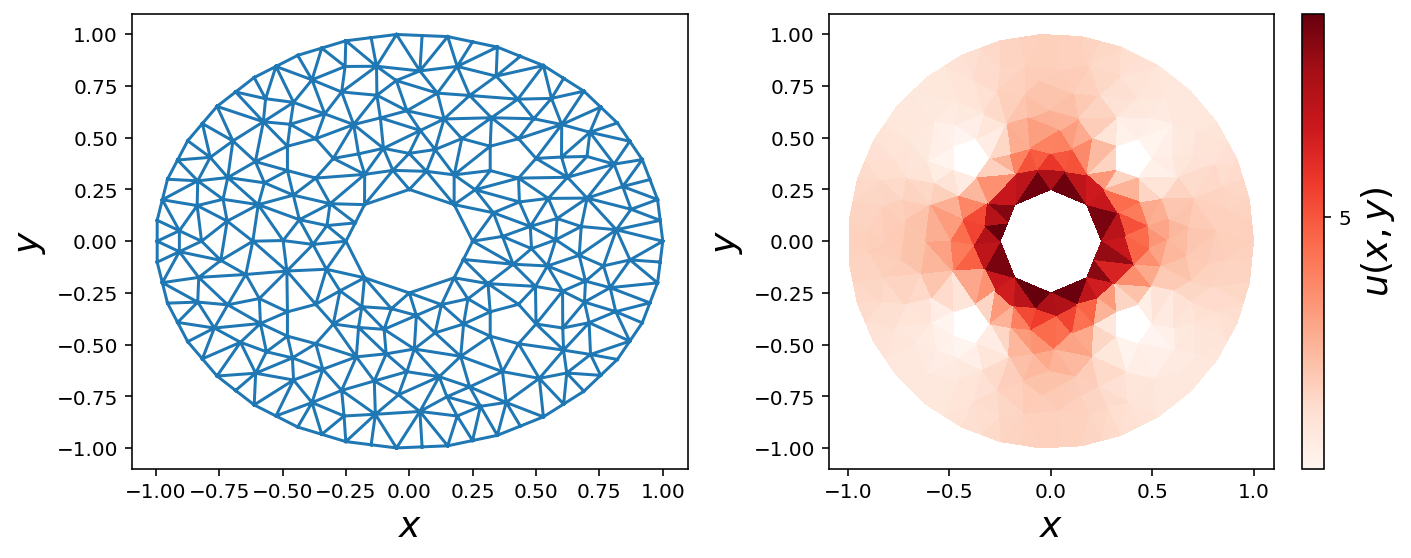

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=18)
ax1.set_ylabel(r"$y$", fontsize=18)

c = ax2.tripcolor(triangulation, 
                  np.array(u_sol.vector()), 
                  cmap=mpl.cm.get_cmap("Reds"))
cb = plt.colorbar(c, ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=18)
ax2.set_ylabel(r"$y$", fontsize=18)
cb.set_label(r"$u(x, y)$", fontsize=18)
cb.set_ticks([0.0, 5, 10, 15])

#fig.savefig("ch11-fdm-2d-ex4.pdf")
#fig.savefig("ch11-fdm-2d-ex4.png")
fig.tight_layout()

### Post processing
- Problems with this kind of geometry are difficult to treat with FDM methods but can be handled with FEM. Once we obtain a solution for a FEM problem we can also post-process the solution function in other ways than plotting it. 

- For example, we might be interested in the value of the function along one of the boundaries. For instance, to look at the temperature along the outer radius, to see how much the exterior temperature of the body decreases due to the four cooling pipes. 

- We need a way of singling out the boundary values from the u_sol object. We do this by defining an object that describes the boundary (here using dolfin.AutoSubDomain) and applying it to a new
Function object that is used as a mask for selecting the desired elements from the u_sol and from mesh.coordinates(). In the following we call this mask function **mask_outer**.

In [66]:
outer_boundary = dolfin.AutoSubDomain(lambda x, on_bnd: 
                                      on_bnd and abs(np.sqrt(x[0]**2 + 
                                                             x[1]**2) - 
                                                     r_outer) < 5e-2)

In [67]:
bc_outer   = dolfin.DirichletBC(V, 1, outer_boundary)
mask_outer = dolfin.Function(V)

In [68]:
bc_outer.apply(mask_outer.vector())

In [69]:
u_outer =     u_sol.vector()[mask_outer.vector() == 1]
x_outer = mesh.coordinates()[mask_outer.vector() == 1]
phi     = np.angle(x_outer[:,0]+1j * x_outer[:,1])
order   = np.argsort(phi)

- Plot boundary data vs angle between (x,y) and the x axis.

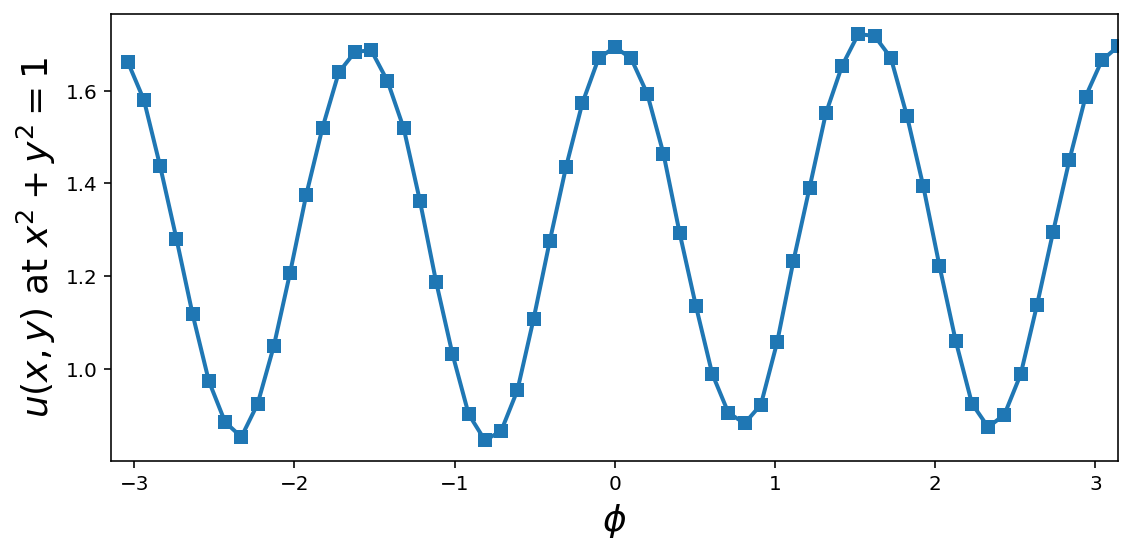

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(phi[order], u_outer[order], 's-', lw=2)
ax.set_ylabel(r"$u(x,y)$ at $x^2+y^2=1$", fontsize=18)
ax.set_xlabel(r"$\phi$", fontsize=18)
ax.set_xlim(-np.pi, np.pi)
fig.tight_layout()
#fig.savefig("ch11-fem-2d-ex5.pdf")

## Mesh refining
- PDE solution accuracy, when found via FEM, is directly related to the element sizes in the mesh - finer meshes = more accuracy, but more computationally difficult.

- To trade accuracy for computation time, you can use a mesh with *non-uniform element distribution*. You can use small elements where the unknown function is expected to change quickly, fewer elements elsewhere.

In [71]:
domain = mshr.Circle(dolfin.Point(0.0, 0.0),1.0) - mshr.Rectangle(
    dolfin.Point(0.0, -1.0), dolfin.Point(1.0, 0.0))

In [72]:
mesh = mshr.generate_mesh(domain, 10)

- Often desirable to use meshes with finer structures near sharp corners. In this case we'll refine the mesh around the edge near the origin.

In [77]:
refined_mesh = mesh
for r in [0.5, 0.25]:
    cell_markers = dolfin.MeshFunction("bool", refined_mesh, dim=2)
    cell_markers.set_all(False)
    for cell in dolfin.cells(refined_mesh):
        if cell.distance(dolfin.Point(.0, .0)) < r:
            cell_markers[cell] = True
    refined_mesh = dolfin.refine(refined_mesh, cell_markers)
    
def mesh_triangulation(mesh):
    coords = mesh.coordinates()
    triangles = mesh.cells()
    triangulation = mpl.tri.Triangulation(coords[:,0],
                                          coords[:,1])
    return triangulation

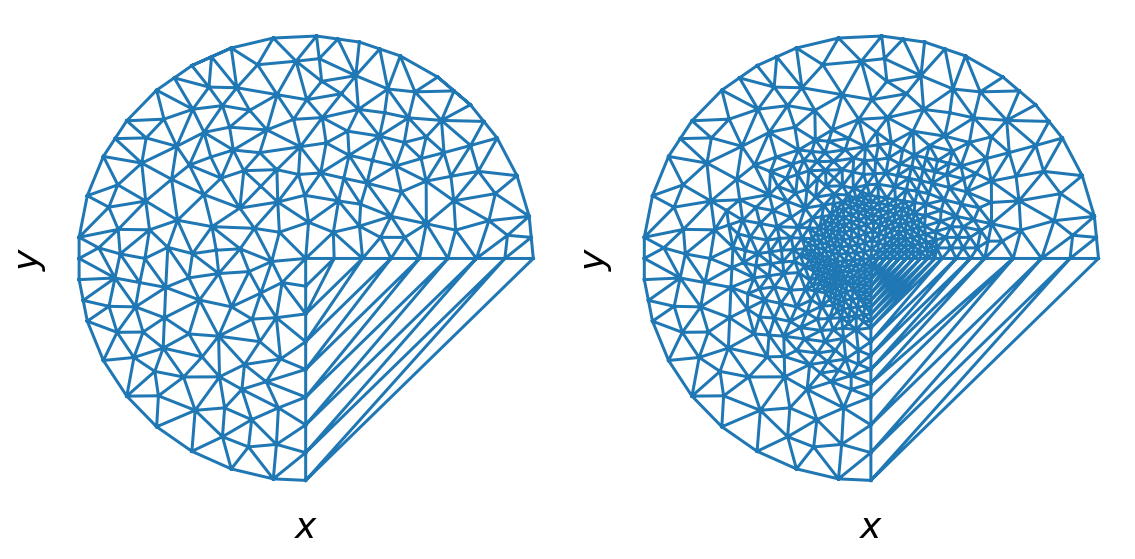

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
 
ax1.triplot(mesh_triangulation(mesh))
ax2.triplot(mesh_triangulation(refined_mesh))

for ax in [ax1, ax2]:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')

    ax.set_xlabel(r"$x$", fontsize=18)
    ax.set_ylabel(r"$y$", fontsize=18)
 
#fig.savefig("ch11-fem-2d-mesh-refine.pdf")
#fig.savefig("ch11-fem-2d-mesh-refine.png")
fig.tight_layout()

### Refined mesh - Neumann boundary conditions

- Another example of steady-state heat equation.
- Use refined mesh for 3/4 of unit circle where we impose Neumann boundary conditions on the vertical & horizontal axes of the missing quarter.

In [79]:
mesh = refined_mesh
V    = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
u    = dolfin.TrialFunction(V)
v    = dolfin.TestFunction(V)
a    = dolfin.inner(dolfin.nabla_grad(u), 
                    dolfin.nabla_grad(v)) * dolfin.dx
f    = dolfin.Constant(0.0)
L    = f*v*dolfin.dx

In [80]:
boundary_parts = dolfin.MeshFunction("size_t",mesh,
                                     mesh.topology().dim()-1)

- define function for selecting boundary points

In [82]:
def v_boundary_func(x,on_boundary):
    x,y = x[0],x[1]
    return on_boundary and abs(x)<1e-4 and y<0.0

v_boundary = dolfin.AutoSubDomain(v_boundary_func)
v_boundary.mark(boundary_parts,0)

def h_boundary_func(x,on_boundary):
    x,y = x[0],x[1]
    return on_boundary and abs(y)<1e-4 and x>0.0

h_boundary = dolfin.AutoSubDomain(h_boundary_func)
h_boundary.mark(boundary_parts,0)


- use same method for defining Dirichlet boundary conditions

In [83]:
def outer_boundary_func(x,on_boundary):
    x,y = x[0],x[1]
    return on_boundary and abs(x**2 + y**2) < 1e-2

outer_boundary = dolfin.AutoSubDomain(outer_boundary_func)
outer_boundary.mark(boundary_parts,2)
bc = dolfin.DirichletBC(V,dolfin.Constant(0.0),boundary_parts,2)

- Create PDE weak-form representation
- Last two lines: added terms for Neumann boundary conditions for vertical & horizonal mesh edges, denoted by 0,1.

In [84]:
dx = dolfin.dx(domain=mesh, subdomain_data=boundary_parts)
a  = dolfin.inner(dolfin.nabla_grad(u),
                  dolfin.nabla_grad(v)) * dx
f =  dolfin.Constant(0.0)
g_v = dolfin.Constant(-2.0)
g_h = dolfin.Constant( 1.0)
L   =   f*v*dolfin.dx(  domain=mesh, subdomain_data=boundary_parts)
L  += g_v*v*dolfin.ds(0,domain=mesh, subdomain_data=boundary_parts)
L  += g_h*v*dolfin.ds(1,domain=mesh, subdomain_data=boundary_parts)

- solve it

In [86]:
u_sol = dolfin.Function(V)
dolfin.solve(a == L, u_sol, bc)

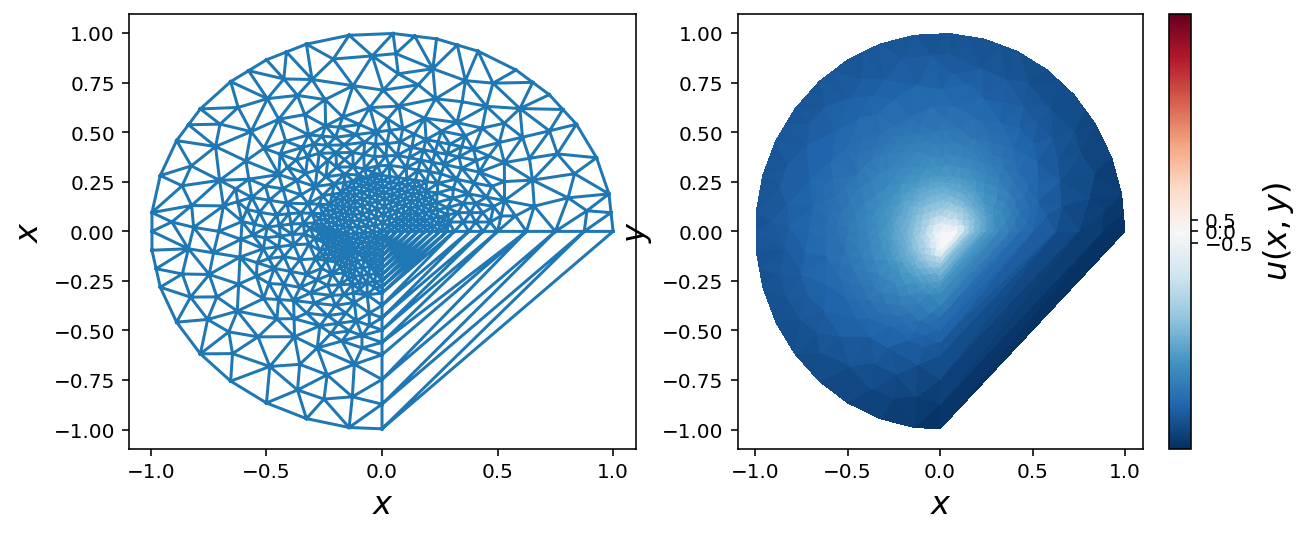

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
triangulation = mesh_triangulation(mesh)
ax1.triplot(triangulation)
ax1.set_xlabel(r"$x$", fontsize=16)
ax1.set_ylabel(r"$x$", fontsize=16)

data = np.array(u_sol.vector())
norm = mpl.colors.Normalize(-abs(data).max(),
                             abs(data).max())
c = ax2.tripcolor(triangulation,
                  data,
                  norm=norm,
                  cmap=mpl.cm.get_cmap("RdBu_r"))
cb = plt.colorbar(c,ax=ax2)
ax2.set_xlabel(r"$x$", fontsize=16)
ax2.set_ylabel(r"$y$", fontsize=16)
cb.set_label(r"$u(x, y)$", fontsize=16)
cb.set_ticks([-.5, 0, .5])